# Time Series Analysis
## By Jiawen WU
Data Preprocessing, Random Walk and ARIMA algorithms are included in this notebook.

Please run auto_arima of pyramid.arima under Python 2.7 and download required dependencies.

In [1]:
#Under python3 and python2.7
import os
import sys

import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt 
import matplotlib as mpl
from pandas import DataFrame

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

from random import seed
from random import random

from sklearn.metrics import mean_squared_error
from math import sqrt

from io import StringIO

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm




In [ ]:
#Under python2.7
from pyramid.arima import auto_arima

In [4]:
def read_and_wash(calendar, listing):
    listings = listing.loc[:,['id', 'room_type', 'accommodates']]
    merged = pd.merge(calendar, listings, left_on='listing_id', right_on='id')
    washed = merged[['listing_id', 'date', 'price', 'room_type', 'accommodates']]
    washed = washed[pd.notnull(washed['price'])]
    washed['price_new'] = washed['price'].apply(lambda value: float(value.replace(',' , '')[1:]))
    washed['accommodates_new'] = washed['accommodates'].apply(lambda value: ('A' if int(value) <= 2 else 'B') if int(value) <= 4 else 'C')
    
    washed['type_new'] = washed.apply(lambda row: type_new(row), axis = 1)
    
    return washed

In [5]:
def type_new(row):
    if row['room_type'] == 'Private room':
        if row['accommodates_new'] == 'A':
            return 'PA'
        elif row['accommodates_new'] == 'B':
            return 'PB'
        else:
            return 'PC'
    elif row['room_type'] == 'Entire home/apt':
        if row['accommodates_new'] == 'A':
            return 'EA'
        elif row['accommodates_new'] == 'B':
            return 'EB'
        else:
            return 'EC'
    else:
        if row['accommodates_new'] == 'A':
            return 'SA'
        elif row['accommodates_new'] == 'B':
            return 'SB'
        else:
            return 'SC'


In [6]:
calendar = pd.read_csv("calendar.csv", sep=",")
listings = pd.read_csv("listings.csv", sep=",")
    
washed = read_and_wash(calendar, listings)
washed.head()

,listing_id,date,price,room_type,accommodates,price_new,accommodates_new,type_new
293,2818,2019-01-31,$59.00,Private room,2,59.0,A,PA
294,2818,2019-01-30,$59.00,Private room,2,59.0,A,PA
295,2818,2019-01-29,$59.00,Private room,2,59.0,A,PA
296,2818,2019-01-28,$59.00,Private room,2,59.0,A,PA
297,2818,2019-01-27,$59.00,Private room,2,59.0,A,PA


In [ ]:
calendar12 = pd.read_csv("calendar12.csv", sep=",")
listings12 = pd.read_csv("listings12.csv", sep=",")
    
washed12 = read_and_wash(calendar12, listings12)
washed12 = washed12[washed12.date.str.startswith('2018-12')]

In [12]:
calendar_2018 = pd.read_csv("calendar2018.csv", sep=",", encoding="windows-1252")
listings_2018 = pd.read_csv("listings2018.csv", sep=",")

washed_2018 = read_and_wash(calendar_2018, listings_2018)
washed_2018 = washed_2018[washed_2018.date.str.startswith('2018')]
washed_2018 = washed_2018[~washed_2018.date.str.startswith('2018-12')]
washed_2018 = washed_2018.append(washed12)
washed_2018.head()

,listing_id,date,price,room_type,accommodates,price_new,accommodates_new,type_new
446,16682109,2018-06-30,$42.00,Private room,2,42.0,A,PA
447,16682109,2018-06-29,$42.00,Private room,2,42.0,A,PA
448,16682109,2018-06-28,$42.00,Private room,2,42.0,A,PA
449,16682109,2018-06-27,$42.00,Private room,2,42.0,A,PA
450,16682109,2018-06-26,$42.00,Private room,2,42.0,A,PA


In [28]:
washed.to_csv("washed2019.csv", sep='\t', encoding='utf-8')
washed_2018.to_csv("washed2018.csv", sep='\t', encoding='utf-8')

In [2]:
washed = pd.read_csv("washed2019.csv", sep='\t', encoding='utf-8')
washed_2018 = pd.read_csv("washed2018.csv", sep='\t', encoding='utf-8')

In [3]:
def random_walk_func(v, t):
    movement = -1*t if random() < 0.5 else t
    return v + movement

In [4]:
def group_data(X):
    print(X.head())
    origin = np.array([])
    origin = X.loc[X['type_new']=='EA'][0:365]['price_new'].values
    origin = np.vstack([origin, X.loc[X['type_new']=='EB'][0:365]['price_new'].values])
    origin = np.vstack([origin, X.loc[X['type_new']=='EC'][0:365]['price_new'].values])
    origin = np.vstack([origin, X.loc[X['type_new']=='PA'][0:365]['price_new'].values])
    origin = np.vstack([origin, X.loc[X['type_new']=='PB'][0:365]['price_new'].values])
    origin = np.vstack([origin, X.loc[X['type_new']=='PC'][0:365]['price_new'].values])
    origin = np.vstack([origin, X.loc[X['type_new']=='SA'][0:365]['price_new'].values])
    origin = np.vstack([origin, X.loc[X['type_new']=='SB'][0:365]['price_new'].values])

    table = pd.DataFrame({'EA':origin[0,:],'EB':origin[1,:],'EC':origin[2,:],'PA':origin[3,:],'PB':origin[4,:],'PC':origin[5,:],'SA':origin[6,:],'SB':origin[7,:]})

    return table

In [19]:
def random_walk(X_train, X_valid, multiplies):
    X_train_group = X_train
    X_valid_group = X_valid
    result = np.array([])
    rmses = []
    r2s = []
    maes = []
    accus = []
    y_true = []
    y_pred = []
    type_new = ['EA', 'EB', 'EC', 'PA', 'PB', 'PC', 'SA', 'SB']
    for i in range(8):
        train = X_train_group.loc[(X_train_group['type_new']==type_new[i])].reset_index()[0:365]
        mean = train['price_new'].mean()
        valid = X_valid_group.loc[(X_valid_group['type_new']==type_new[i])].reset_index()[0:365]
        print(train.shape)
        print(valid.shape)
        
        seed(i)
        #multiplies = 3
        prev = train['price_new'][364]
        price_pred = []
        for j in range(365):
            prev = random_walk_func(prev, multiplies)
            price_pred.append(prev)
            #group_table[type_new[i]].loc(j) = [pred]
        train['price_pred'] = price_pred
        
        y_true = y_true + [list(valid['price_new'].values)]
        y_pred = y_pred + [price_pred]
        
        result = np.vstack([result, list(valid['price_new'].values) + price_pred]) if i>0 else np.array(list(valid['price_new'].values) + price_pred)
        compare = np.vstack([compare, list(train['price_new'].values) + list(valid['price_new'].values)]) if i>0 else np.array(list(train['price_new'].values) + list(valid['price_new'].values))
        
        #rmse
        merge_check = valid[['date', 'price_new']]
        merge_check['price_pred'] = price_pred
        rmse = sqrt(mean_squared_error(merge_check['price_pred'].values, merge_check['price_new'].values))
        rmses.append(rmse)
        
        #r2
        y_true = list(merge_check['price_new'])
        y_pred = list(merge_check['price_pred'])
        r2 = r2_score(y_true, y_pred)
        r2s.append(r2)
        
        # Calculate the absolute errors
        errors = abs(np.array(y_pred) - np.array(y_true))
        # Print out the mean absolute error (mae)
        mae = np.mean(errors)
        maes.append(mae)
        
        # Calculate mean absolute percentage error (MAPE)
        mape = 100 * (errors / np.array(y_true))
        # Calculate and display accuracy
        accu = 100 - np.mean(mape)
        accus.append(accu)
        
    print("Average RMSE:", sum(rmses)/len(rmses))
    print("Average R2:", sum(r2s)/len(r2s))
    print("Average MAE:", sum(maes)/len(maes))
    print("Average Accuracy:", sum(accus)/len(accus))
    
    draw_table = pd.DataFrame({'EA':result[0,:],'EB':result[1,:],'EC':result[2,:],'PA':result[3,:],'PB':result[4,:],'PC':result[5,:],'SA':result[6,:],'SB':result[7,:]})
    
    compare_table = pd.DataFrame({'EA':compare[0,:],'EB':compare[1,:],'EC':compare[2,:],'PA':compare[3,:],'PB':compare[4,:],'PC':compare[5,:],'SA':compare[6,:],'SB':compare[7,:]})
    
    plt.scatter(y_true, y_pred, s=1, color='purple')
    plt.show()


(365, 4)
(365, 4)
(365, 4)
(365, 4)
(365, 4)
(365, 4)
(365, 4)
(365, 4)
(365, 4)
(365, 4)
(365, 4)
(365, 4)
(365, 4)
(365, 4)
(365, 4)
(365, 4)
Average RMSE: 45.4599650048934
Average R2: -3.0841196392580525
Average MAE: 39.20580676556812
Average Accuracy: 79.12585554536128


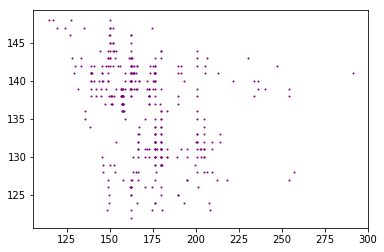

In [20]:
# out of sample
X_train_group = washed_2018.groupby(['date','type_new'])['price_new'].mean().reset_index()
X_valid_group = washed.groupby(['date','type_new'])['price_new'].mean().reset_index()

for i in range(1):
    random_walk(X_train_group, X_valid_group, i+1)

In [26]:
#Under python2.7
#Change Jupyter Notebook kernel to Python2
def autoarima(X_train, X_valid):
    X_train_group = X_train
    X_valid_group = X_valid
    result = np.array([])
    rmses = []
    r2s = []
    maes = []
    accus = []
    type_new = ['EA', 'EB', 'EC', 'PA', 'PB', 'PC', 'SA', 'SB']
    for i in range(8):
        print(list(X_train_group))
        train = X_train_group.loc[(X_train_group['type_new']==type_new[i])].reset_index()[0:365]
        valid = X_valid_group.loc[(X_valid_group['type_new']==type_new[i])].reset_index()[0:365]
        
        data = pd.concat([train['price_new']], axis=1, keys=['price'])
        
        #Fit auto_arima
        model = auto_arima(data, trace=True, seasonal=True, m=12, error_action='ignore', suppress_warnings=True)
        model.fit(data)
        forecast = model.predict(n_periods=365)
        price_pred = list(forecast)
        
        
        result = np.vstack([result, list(valid['price_new'].values) + price_pred]) if i>0 else np.array(list(valid['price_new'].values) + price_pred)
        compare = np.vstack([compare, list(train['price_new'].values) + list(valid['price_new'].values)]) if i>0 else np.array(list(train['price_new'].values) + list(valid['price_new'].values))
        
        #rmse
        merge_check = valid[['date', 'price_new']]
        #print(merge_check.shape)
        merge_check['price_pred'] = price_pred
        rmse = sqrt(mean_squared_error(merge_check['price_pred'].values, merge_check['price_new'].values))
        rmses.append(rmse)
        
        #r2
        y_true = list(merge_check['price_new'])
        y_pred = list(merge_check['price_pred'])
        r2 = r2_score(y_true, y_pred)
        r2s.append(r2)
        
        # Calculate the absolute errors
        errors = abs(np.array(y_pred) - np.array(y_true))
        # Print out the mean absolute error (mae)
        mae = np.mean(errors)
        maes.append(mae)
        
        # Calculate mean absolute percentage error (MAPE)
        mape = 100 * (errors / np.array(y_true))
        # Calculate and display accuracy
        accu = 100 - np.mean(mape)
        accus.append(accu)
        
        print "RMSE:", rmse
        print "R2:", r2
        print "MAE:", mae
        print "Accuracy:", accu
        
    print "Average RMSE:", sum(rmses)/len(rmses)
    print "Average R2:", sum(r2s)/len(r2s)
    print "Average MAE:", sum(maes)/len(maes)
    print "Average Accuracy:", sum(accus)/len(accus)
    
    draw_table = pd.DataFrame({'EA':result[0,:],'EB':result[1,:],'EC':result[2,:],'PA':result[3,:],'PB':result[4,:],'PC':result[5,:],'SA':result[6,:],'SB':result[7,:]})
    draw_table.plot(x=None, y=['EA'], figsize=(10,4))
    
    return draw_table
    

['date', 'type_new', 'price_new']
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=1903.796, BIC=1911.590, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=1871.801, BIC=1887.390, Fit time=0.172 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=1862.471, BIC=1878.060, Fit time=0.167 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=1863.826, BIC=1883.311, Fit time=0.347 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=1895.337, BIC=1907.029, Fit time=0.033 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 2, 12); AIC=1863.924, BIC=1883.410, Fit time=0.684 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=1855.097, BIC=1878.480, Fit time=1.360 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=1851.953, BIC=1879.234, Fit time=1.914 seconds
Fit AR

Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 2, 12); AIC=2881.643, BIC=2908.923, Fit time=2.047 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 0, 2, 12); AIC=2879.865, BIC=2914.939, Fit time=3.922 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=2879.815, BIC=2907.095, Fit time=0.905 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=2880.007, BIC=2903.389, Fit time=0.575 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=2875.620, BIC=2910.694, Fit time=4.840 seconds
Total fit time: 38.510 seconds
RMSE: 66.984035482
R2: -0.43198315978906465
MAE: 51.19235786859494
Accuracy: 90.74844858705532
['date', 'type_new', 'price_new']
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=1826.515, BIC=1834.310, Fit time=0.011 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=1774.484, BIC=1790.073, Fit time=0.

Fit ARIMA: order=(5, 1, 4) seasonal_order=(0, 0, 0, 12); AIC=2985.268, BIC=3028.137, Fit time=2.435 seconds
Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 0, 0, 12); AIC=2988.080, BIC=3027.052, Fit time=2.281 seconds
Fit ARIMA: order=(5, 1, 3) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(5, 1, 5) seasonal_order=(0, 0, 0, 12); AIC=2986.640, BIC=3033.406, Fit time=2.702 seconds
Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(5, 1, 4) seasonal_order=(1, 0, 0, 12); AIC=2987.935, BIC=3034.701, Fit time=5.834 seconds
Total fit time: 107.287 seconds
RMSE: 108.72933471
R2: -3.4414111709271076
MAE: 98.6860942528975
Accuracy: 60.84139360010045
['date', 'type_new', 'price_new']
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=2828.801, BIC=2836.595, Fit time=0.027 seconds
Fit ARIMA: or

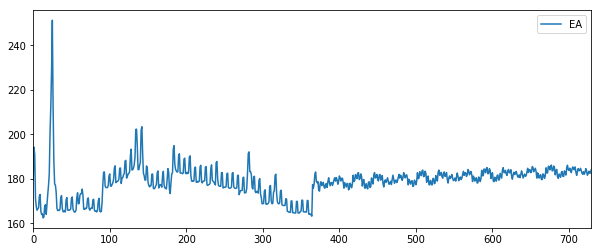

In [23]:
X_train_group = washed_2018.groupby(['date','type_new'])['price_new'].mean().reset_index()
X_valid_group = washed.groupby(['date','type_new'])['price_new'].mean().reset_index()
table = autoarima(X_train_group, X_valid_group)

In [65]:
def sarimax(X_train, X_valid, myorder, myseasonalorder):
    X_train_group = X_train
    X_valid_group = X_valid
    result = np.array([])
    rmses = []
    r2s = []
    maes = []
    mapes = []
    accus = []
    y_true = []
    y_pred = []
    
    type_new = ['EA', 'EB', 'EC', 'PA', 'PB', 'PC', 'SA', 'SB']
    for i in range(8):
        print(list(X_train_group))
        train = X_train_group.loc[(X_train_group['type_new']==type_new[i])].reset_index()[0:365]
        valid = X_valid_group.loc[(X_valid_group['type_new']==type_new[i])].reset_index()[0:360]
        
        data = pd.concat([train['price_new']], axis=1, keys=['price'])
        
        mod = sm.tsa.statespace.SARIMAX(data, order=myorder[i], seasonal_order=myseasonalorder[i], enforce_stationarity=False, enforce_invertibility=False)
        results = mod.fit()
        print (results.aic)
        predict = results.predict(alpha=0.05, start=0, end=365+12-1)
        price_pred = list(predict[365:])
        
        forecast = []
        for j in range(12):
            for k in range(30):
                forecast = forecast + [price_pred[j]]
        price_pred = forecast
        
        y_true = y_true + [list(valid['price_new'].values)]
        y_pred = y_pred + [price_pred]
        
        result = np.vstack([result, list(valid['price_new'].values) + price_pred]) if i>0 else np.array(list(valid['price_new'].values) + price_pred)
        compare = np.vstack([compare, list(train['price_new'].values) + list(valid['price_new'].values)]) if i>0 else np.array(list(train['price_new'].values) + list(valid['price_new'].values))
        
        #rmse
        merge_check = valid[['date', 'price_new']]
        merge_check['price_pred'] = price_pred
        rmse = sqrt(mean_squared_error(merge_check['price_pred'].values, merge_check['price_new'].values))
        rmses.append(rmse)
        
        #r2
        y_true = list(merge_check['price_new'])
        y_pred = list(merge_check['price_pred'])
        r2 = r2_score(y_true, y_pred)
        r2s.append(r2)
        
        # Calculate the absolute errors
        errors = abs(np.array(y_pred) - np.array(y_true))
        # Print out the mean absolute error (mae)
        mae = np.mean(errors)
        maes.append(mae)
        
        # Calculate mean absolute percentage error (MAPE)
        mape = 100 * (errors / np.array(y_true))
        mapes.append(np.mean(mape))
        
        # Calculate and display accuracy
        accu = 100 - np.mean(mape)
        accus.append(accu)
        
        print ("RMSE:", rmse)
        print ("R2:", r2)
        print ("MAE:", mae)
        print ("MAPE:", np.mean(mape))
        print ("Accuracy:", accu)
        
    print ("Average RMSE:", sum(rmses)/len(rmses))
    print ("Average R2:", sum(r2s)/len(r2s))
    print ("Average MAE:", sum(maes)/len(maes))
    print ("Average MAPE:", sum(mapes)/len(mapes))
    print ("Average Accuracy:", sum(accus)/len(accus))
    
    draw_table = pd.DataFrame({'EA':result[0,:],'EB':result[1,:],'EC':result[2,:],'PA':result[3,:],'PB':result[4,:],'PC':result[5,:],'SA':result[6,:],'SB':result[7,:]})
    draw_table.plot(x=None, y=type_new, figsize=(10,4))
    
    compare_table = pd.DataFrame({'EA':compare[0,:],'EB':compare[1,:],'EC':compare[2,:],'PA':compare[3,:],'PB':compare[4,:],'PC':compare[5,:],'SA':compare[6,:],'SB':compare[7,:]})
    
    plt.scatter(y_true, y_pred, s=1, color='purple')
    
    return draw_table
    


['date', 'type_new', 'price_new']
1588.2077527832894
RMSE: 9.586743825671148
R2: 0.01405801827685893
MAE: 6.857185008823287
MAPE: 3.872167650349152
Accuracy: 96.12783234965084
['date', 'type_new', 'price_new']
1766.9222348126773
RMSE: 17.432688219809943
R2: 0.037845167780836464
MAE: 12.69898463086268
MAPE: 4.6492530371962975
Accuracy: 95.3507469628037
['date', 'type_new', 'price_new']
2564.402347941285
RMSE: 68.1514126903903
R2: -0.48586329807868167
MAE: 54.12113147989609
MAPE: 9.784108824555384
Accuracy: 90.21589117544461
['date', 'type_new', 'price_new']
1472.0606793512725
RMSE: 16.462513954782384
R2: -1.5071495917924511
MAE: 12.357872205096344
MAPE: 11.673998167789652
Accuracy: 88.32600183221035
['date', 'type_new', 'price_new']
2003.2213204112172
RMSE: 26.008035485088335
R2: -1.0723025182431893
MAE: 20.182174952389865
MAPE: 13.021896899613516
Accuracy: 86.97810310038648
['date', 'type_new', 'price_new']
2786.8774593416965
RMSE: 71.76131269327927
R2: -0.9085022917443291
MAE: 60.0000

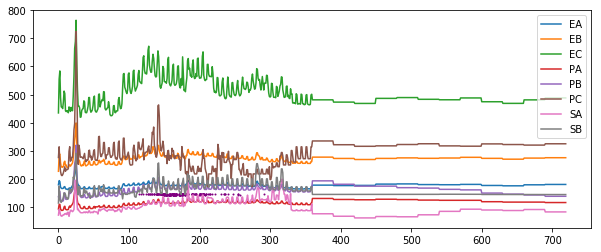

In [66]:
X_train_group = washed_2018.groupby(['date','type_new'])['price_new'].mean().reset_index()
X_valid_group = washed.groupby(['date','type_new'])['price_new'].mean().reset_index()
myorder = [(4,1,0),(4,1,0),(4,1,0),(2,1,1),(4,0,0),(2,1,1),(4,1,2),(1,1,0)]
myseasonalorder = [(2,0,2,12),(2,0,2,12),(2,0,2,12),(2,0,2,12),(2,0,2,12),(2,0,2,12),(2,0,1,12),(2,0,2,12)]
table = sarimax(X_train_group, X_valid_group, myorder, myseasonalorder)

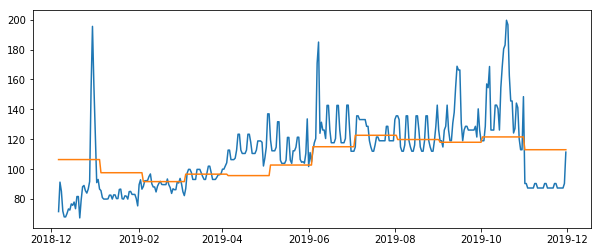

In [97]:
valid = X_valid_group.loc[(X_valid_group['type_new']=='SA')].reset_index()[0:360]
table2 = pd.DataFrame({'True': list(table['SA'][0:360]), 'Pred': list(table['SA'][360:]+30), 'time': list(valid['date'])})
table2['time'] = pd.to_datetime(table2['time']) 
plt.figure(figsize=(10,4))
plt.plot(table2.time.values, table2[['True', 'Pred']].values)

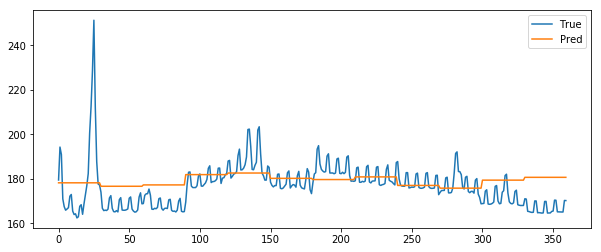

In [76]:
table2 = pd.DataFrame({'True': list(table['EA'][0:360]), 'Pred': list(table['EA'][360:])})
table2.plot(x=None, y=['True', 'Pred'], figsize=(10,4))

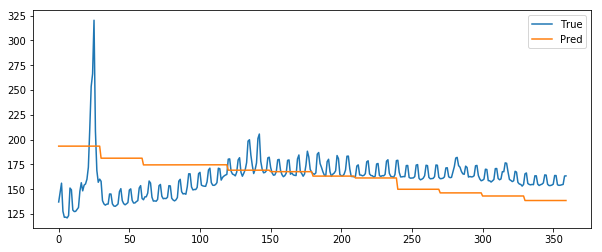

In [77]:
table2 = pd.DataFrame({'True': list(table['PB'][0:360]), 'Pred': list(table['PB'][360:])})
table2.plot(x=None, y=['True', 'Pred'], figsize=(10,4))